# Mesh convergence

strong form of the boundary value problem
$$
\begin{align*}
&\text{Find}~u(\textbf{x}): \Omega \to \mathbb{R}~	ext{such that} \\
&\begin{cases}
\mathcal{L} u = f & \forall\textbf{x}\in\Omega \\
u=u_{\text{D}} & \forall \textbf{x}\in\partial\Omega \\
\end{cases}~.
\end{align*}
$$

method of manufactured solutions
$$
\begin{align*}
&\text{Find}~u(\textbf{x}): \Omega \to \mathbb{R}~	ext{such that} \\
&\begin{cases}
\mathcal{L} u = \mathcal{L}u_{\text{e}} & \forall\textbf{x}\in\Omega \\
u=u_{\text{e}} & \forall \textbf{x}\in\partial\Omega \\
\end{cases}~.
\end{align*}
$$

The goal is to demonstrate that the error norm tends to zero as mesh cell cell size tends to zero. Asymptotically as $h\to0$ with $e=u_{\text{e}} - u$ being the error, we expect

$$||e||\sim C h^r$$

for some constant $C>0$ and convergence rate $r>0$. We consider the $L_2$, $\ell_2$ and $\ell_\infty$ norms defined by

$$||e||_{L_p}=\left(\int_\Omega |e|^p~\text{d}\Omega\right)^{1/p}$$

$$||e||_{\ell_p}=\left(\sum_j|E_j|^p\right)^{1/p}$$

## convergence of the Poisson equation on a unit square

$$
\mathbb{S}=
\begin{cases}
\Omega = [0, 1] \times [0, 1] \\
\mathcal{L}=\nabla^2 \\
u_{\text{e}}(x,y)=\cos(2\pi x)\cos(2\pi y) \\
\end{cases}
$$

In [ ]:
from typing import Callable
import numpy as np
from ufl.core.expr import Expr
from ufl import SpatialCoordinate, div, grad, cos
from dolfinx.fem import FunctionSpace

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import Function
from lucifex.solver import bvp, BoundaryConditions
from lucifex.viz import plot_colormap, plot_line
from lucifex.utils import (
    L_norm, l_norm, set_finite_element_function, 
    interpolate_finite_element_function, nested_dict
)
from lucifex.pde.foundations import poisson



def compute_solutions(
    Nx: int,
    u_exact: Callable[[SpatialCoordinate], Expr],
    cell: str,
    family: str,
    degree: int,
) -> tuple[float, Function, Expr]:
    Lx = 1.0
    h = Lx / Nx
    mesh = rectangle_mesh(Lx, Lx, Nx, Nx, cell)
    boundary = mesh_boundary(
        mesh, 
        {
            "left": lambda x: x[0],
            "right": lambda x: x[0] - Lx,
            "lower": lambda x: x[1],
            "upper": lambda x: x[1] - Lx,
        },
        complete=True,
    )
    fs = FunctionSpace(mesh, (family, degree))

    x = SpatialCoordinate(mesh)
    ue = u_exact(x)
    bcs = BoundaryConditions(
        ("dirichlet", boundary.union, ue),
    )
    f = div(grad(ue))
    u = Function(fs, name='u')
    u_solver = bvp(poisson, bcs)(u, f)
    u_solver.solve()

    return h, u, ue


def compute_norms(
    u: Function,
    ue: Expr,
    degree_raise: int = 0,
    **dx_metadata,
) -> tuple[float, float, float, float]:
    if degree_raise:
        family = u.function_space.ufl_element().family()
        degree = u.function_space.ufl_element().degree()
        fs = FunctionSpace(u.function_space.mesh, (family, degree + degree_raise))
    else:
        fs = u.function_space
        
    u_func = Function(fs)
    u_func.interpolate(u)
    ue_func = Function(fs)
    interpolate_finite_element_function(ue_func, ue)
    e_func = Function(fs)
    set_finite_element_function(e_func, ue_func.x.array - u_func.x.array, ':')

    L2_norm_expr = L_norm('dx', **dx_metadata)(ue - u_func, 2.0)
    L2_norm_func = L_norm('dx', **dx_metadata)(e_func, 2.0)
    l2_norm = l_norm(e_func, 2.0)
    linf_norm = l_norm(e_func, 'inf')

    return np.sqrt(L2_norm_expr), np.sqrt(L2_norm_func), l2_norm, linf_norm


u_exact = lambda x: cos(2 * np.pi * x[0]) * cos(2 * np.pi * x[1])
Nx = (10, 50, 100, 200)
degree_raise = (None, 3)
L2_from_expr = (True, False)

solutions = nested_dict()

for nx in Nx:
    for deg in degree_raise:
        h, u, ue = compute_solutions(nx, u_exact, 'right', 'P', 1)
        L2_norm_expr, L2_norm_func, l2_norm, linf_norm = compute_norms(u, ue, deg)
        solutions['L2_expr'][deg][h] = L2_norm_expr
        solutions['L2_func'][deg][h] = L2_norm_func
        solutions['l2'][deg][h] = l2_norm
        solutions['linf'][deg][h] = linf_norm



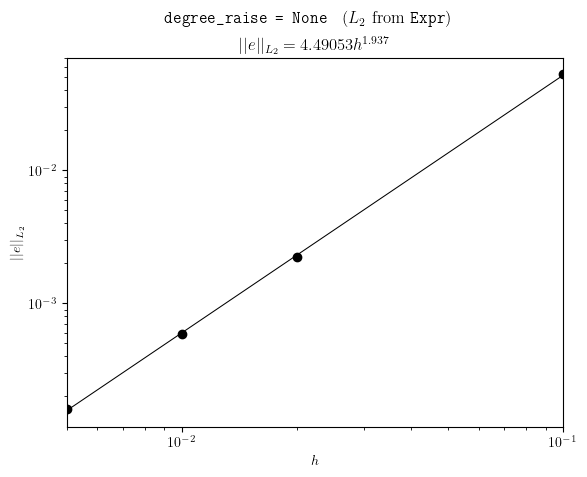

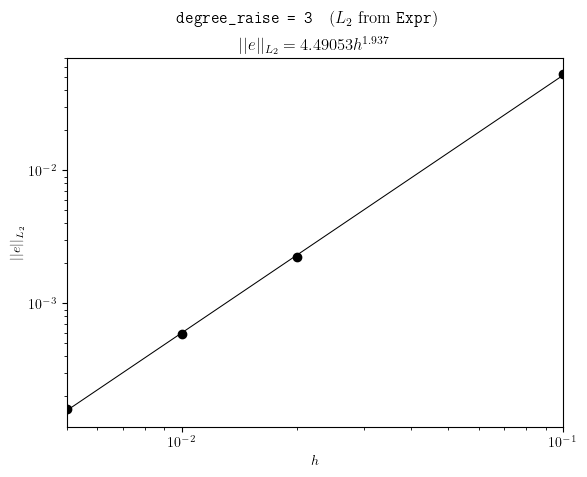

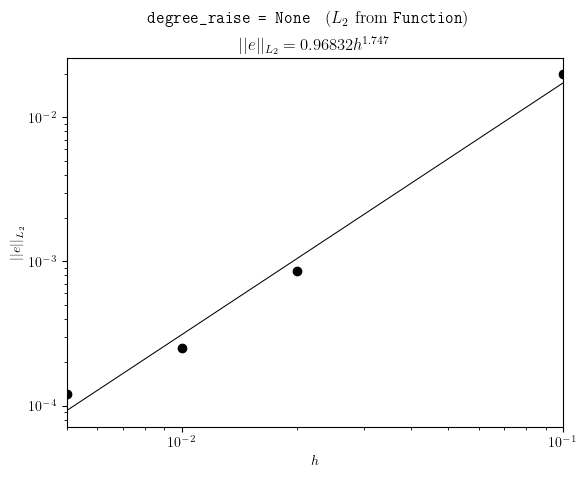

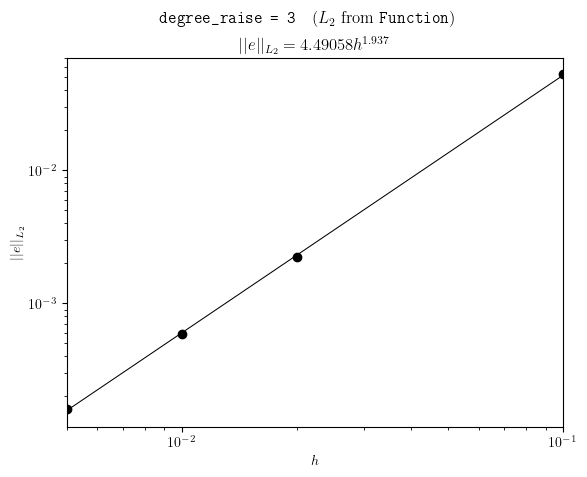

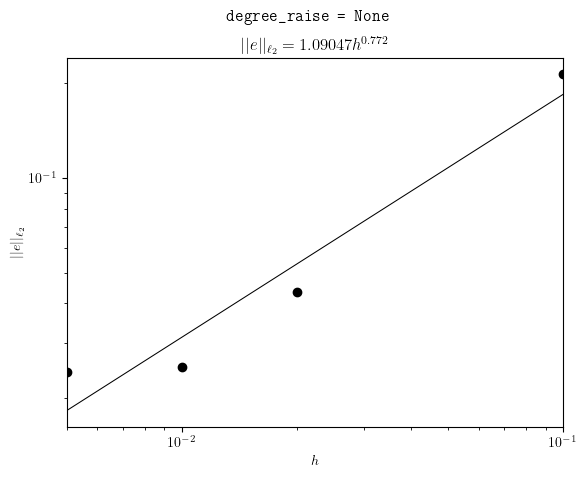

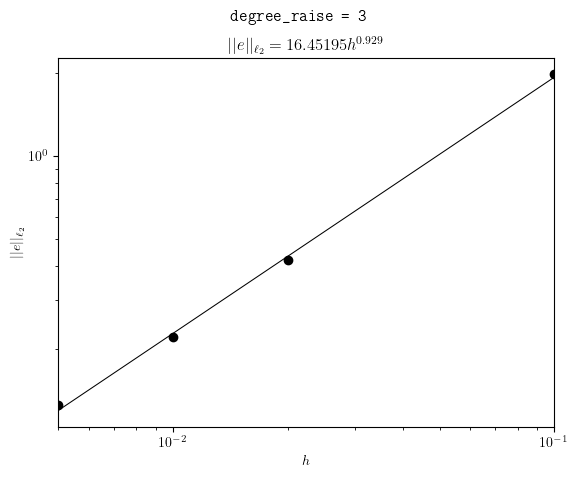

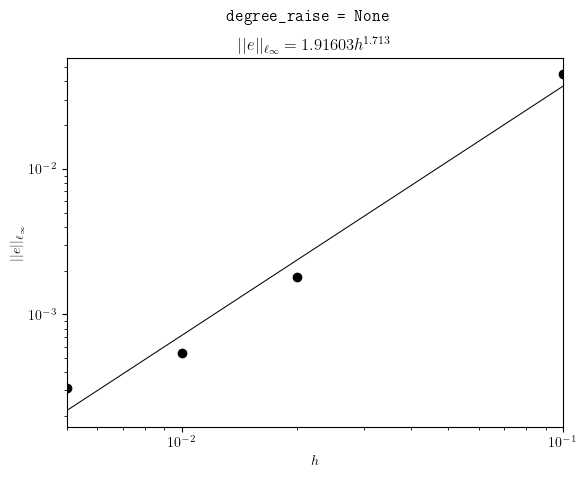

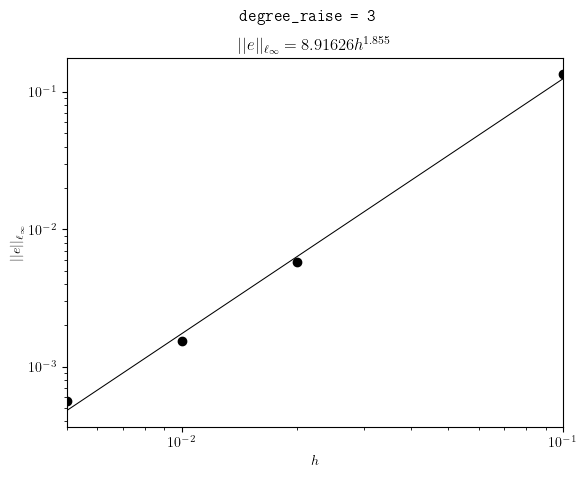

In [ ]:
def plot_convergence(
    x_values: np.ndarray,
    y_values: np.ndarray,
    y_label: str,
    x_label: str = 'h', 
):
    gradient, intercept = np.polyfit(np.log(x_values), np.log(y_values), 1)
    lobf = np.exp(intercept) * x_values ** gradient

    title = f'${y_label}={np.exp(intercept):.5f}h^{{{gradient:.3f}}}$'
    fig, ax = plot_line(
        (x_values, y_values), 
        x_label=f'${x_label}$', 
        y_label=f'${y_label}$', 
        marker='o',
        linestyle='',
        title=title,
    )
    ax.plot(x_values, lobf, color='black', linestyle='solid', linewidth=0.75)
    ax.set_xscale('log')
    ax.set_yscale('log')

    return fig, ax


keys = ('L2_expr', 'L2_func', 'l2', 'linf')
labels = ('||e||_{L_2}', '||e||_{L_2}', '||e||_{\ell_2}', '||e||_{\ell_\infty}')

for key, lbl in zip(keys, labels):
    for deg in degree_raise:
        subdict: dict = solutions[key][deg]
        fig, ax = plot_convergence(
            list(subdict.keys()),
            list(subdict.values()),
            lbl,
        )
        suptitle = f'\\texttt{{degree_raise = {deg}}}'
        if key == 'L2_expr':
            suptitle = f'{suptitle}\quad($L_2$ from \\texttt{{Expr}})'
        if key == 'L2_func':
            suptitle = f'{suptitle}\quad($L_2$ from \\texttt{{Function}})'
        fig.suptitle(suptitle)
